
# 简单的Darcy渗流场频谱分析
Using ``neuralop.utils.spectrum_2d`` to perform spectrum analysis on our small Darcy-Flow example.

This tutorial demonstrates how to analyze the spectral characteristics of the Darcy-Flow dataset,
which provides insights into the frequency content and energy distribution of the vector fields.

For more details on spectrum analysis, users can take a look at this reference: 
https://www.astronomy.ohio-state.edu/ryden.1/ast825/ch7.pdf

## Short summary
Spectral analysis is useful because it allows researchers to study the distribution of energy 
across different scales in a fluid flow. The energy spectrum is analyzed through the Fourier 
transform, a mathematical tool that decomposes a function or signal into its constituent frequencies. 
In a fluid flow, it is used to analyze the distribution of energy across different scales in a flow. 

Specifically, the Fourier transform is applied to the velocity field of the flow, converting it 
into a frequency domain representation. Higher wavenumbers correspond to higher frequencies and 
higher energy, and are much harder to solve as we need higher modes to capture the high-frequency 
behavior of the flow. Overall, this allows researchers to study the energy spectrum, which 
provides insights into the behavior of turbulence and the underlying physical processes.

频谱分析的核心价值在于：帮助科研人员研究流体运动中**不同尺度下的能量分布规律**。
能量谱的分析核心依赖**傅里叶变换** —— 这是一种可以将任意函数/信号，分解为其组成频率分量的数学工具。
在流体力学领域中，傅里叶变换被用来分析流体在不同尺度下的能量分布状态。

具体来说，我们会对流体的速度场执行傅里叶变换，将其从「空间域」转换为「频率域」。
其中**波数越高**，代表对应的频率越高、能量越强，这类高频分量的求解难度也越大，因为需要更高阶的模态才能捕捉流体的高频运动特征。
总而言之，通过能量谱分析，科研人员可以深入研究湍流的运动规律和其背后的物理过程。


## Import dependencies
We first import our `neuralop` library and required dependencies.



In [22]:
import numpy as np
import torch
import matplotlib
matplotlib.rc("font",family='DengXian')
import matplotlib.pyplot as plt
from neuralop.utils import spectrum_2d
from neuralop.data.datasets import load_darcy_flow_small
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 设置随机种子，保证实验结果可复现
torch.manual_seed(0)
np.random.seed(0)

## Define analysis parameters
These parameters control the spectral analysis of our Darcy-Flow dataset



In [23]:
samples = 50  # 本次分析选取的样本数量
s = 16        # 数据集的空间分辨率（16x16的二维网格）
dataset_name = "Darcy 渗流场"  # 数据集名称，用于绘图标题

## Loading the Darcy-Flow dataset
We load the Darcy-Flow dataset with multiple resolutions for spectral analysis



In [24]:
# 加载小型Darcy渗流场数据集
# 返回值说明：训练数据加载器、测试数据加载器字典、数据处理器
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=50,                # 训练集样本数量
    batch_size=50,             # 训练集批次大小
    test_resolutions=[16, 32], # 测试集的分辨率列表：16x16 和 32x32
    n_tests=[50, 50],          # 对应不同分辨率的测试集样本数
    test_batch_sizes=[32],     # 测试集批次大小
    encode_output=False,       # 是否对输出数据做编码，本次分析关闭编码
    data_root="D:\\document\\python\\neural operators\\dataset\\darcy_flow"
)

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 


## Preparing data for spectral analysis
The dataset structure is ['x', 'y'] where 'x' is the permeability field （渗透场）and 'y' is the pressure field（压力场）
We'll analyze the pressure fields ('y') for their spectral characteristics


In [25]:
# 打印原始数据集的渗透场(x)的张量形状，查看数据维度
print("原始数据集渗透场形状:", train_loader.dataset[:samples]["x"].shape)

# 提取压力场数据（模型输出值）用于频谱分析
# squeeze()：删除张量中维度为1的「空通道维度」，简化张量结构
dataset_pred = train_loader.dataset[:samples]["y"].squeeze()

# 打印预处理后压力场的张量形状
shape = dataset_pred.shape
print(f"压力场张量形状: {shape}")

原始数据集渗透场形状: torch.Size([50, 1, 16, 16])
压力场张量形状: torch.Size([50, 16, 16])



## Creating coordinate grids for spectral analysis
We need to define the spatial grid for proper spectral analysis
For 2D grids, we create x and y coordinate arrays

## 构建频谱分析所需的二维空间坐标网格
为了完成标准化的频谱分析，必须先定义对应的空间坐标网格。
针对二维网格数据，我们需要分别创建x轴和y轴的坐标矩阵

In [26]:
# 拆分压力场张量的维度：批量数=1，x轴分辨率，y轴分辨率
batchsize, size_x, size_y = 1, shape[1], shape[2]

# 创建x轴坐标：生成从-1到1的等间距序列，数据类型为torch浮点型
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
# 重塑维度 + 广播：将一维坐标转为 (batchsize, size_x, size_y) 的二维矩阵
gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, size_y])

# 创建y轴坐标：生成从-1到1的等间距序列，数据类型为torch浮点型
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
# 重塑维度 + 广播：将一维坐标转为 (batchsize, size_x, size_y) 的二维矩阵
gridy = gridy.reshape(1, 1, size_y).repeat([batchsize, size_x, 1])

# 拼接x/y坐标矩阵，在最后一个维度合并，得到完整的二维坐标网格
# 最终grid形状：(batchsize, size_x, size_y, 2)
grid = torch.cat((gridx, gridy), dim=-1)


## Computing the energy spectrum
We compute the 2D energy spectrum of the pressure fields using the spectrum_2d utility
This gives us insight into how energy is distributed across different spatial frequencies

## 可视化能量谱结果
能量谱曲线的物理含义：展示「每个波数（空间频率）」对应的能量占比
✅ 核心规律：**波数越高 → 对应的空间尺度越小 → 频率越高**
（小尺度的流体特征对应高频分量，大尺度的流体特征对应低频分量）


In [27]:
# Generate the spectrum of the dataset
# We reshape our samples into the form expected by ``spectrum_2d``: ``(n_samples, h, w)``
truth_sp = spectrum_2d(dataset_pred.reshape(samples * batchsize, s, s), s)


## Visualizing the energy spectrum
The energy spectrum shows how much energy is contained in each wavenumber (spatial frequency)
Higher wavenumbers correspond to smaller spatial scales and higher frequencies



C:\Users\MR\AppData\Local\Temp\ipykernel_15956\2102993040.py:38: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_15956\2102993040.py:38: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_15956\2102993040.py:38: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_15956\2102993040.py:38: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_15956\2102993040.py:38: UserWarning: Glyph 28183 (\N{CJK UNIFIED IDEOGRAPH-6E17}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_15956\2102993040.py:38: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEO

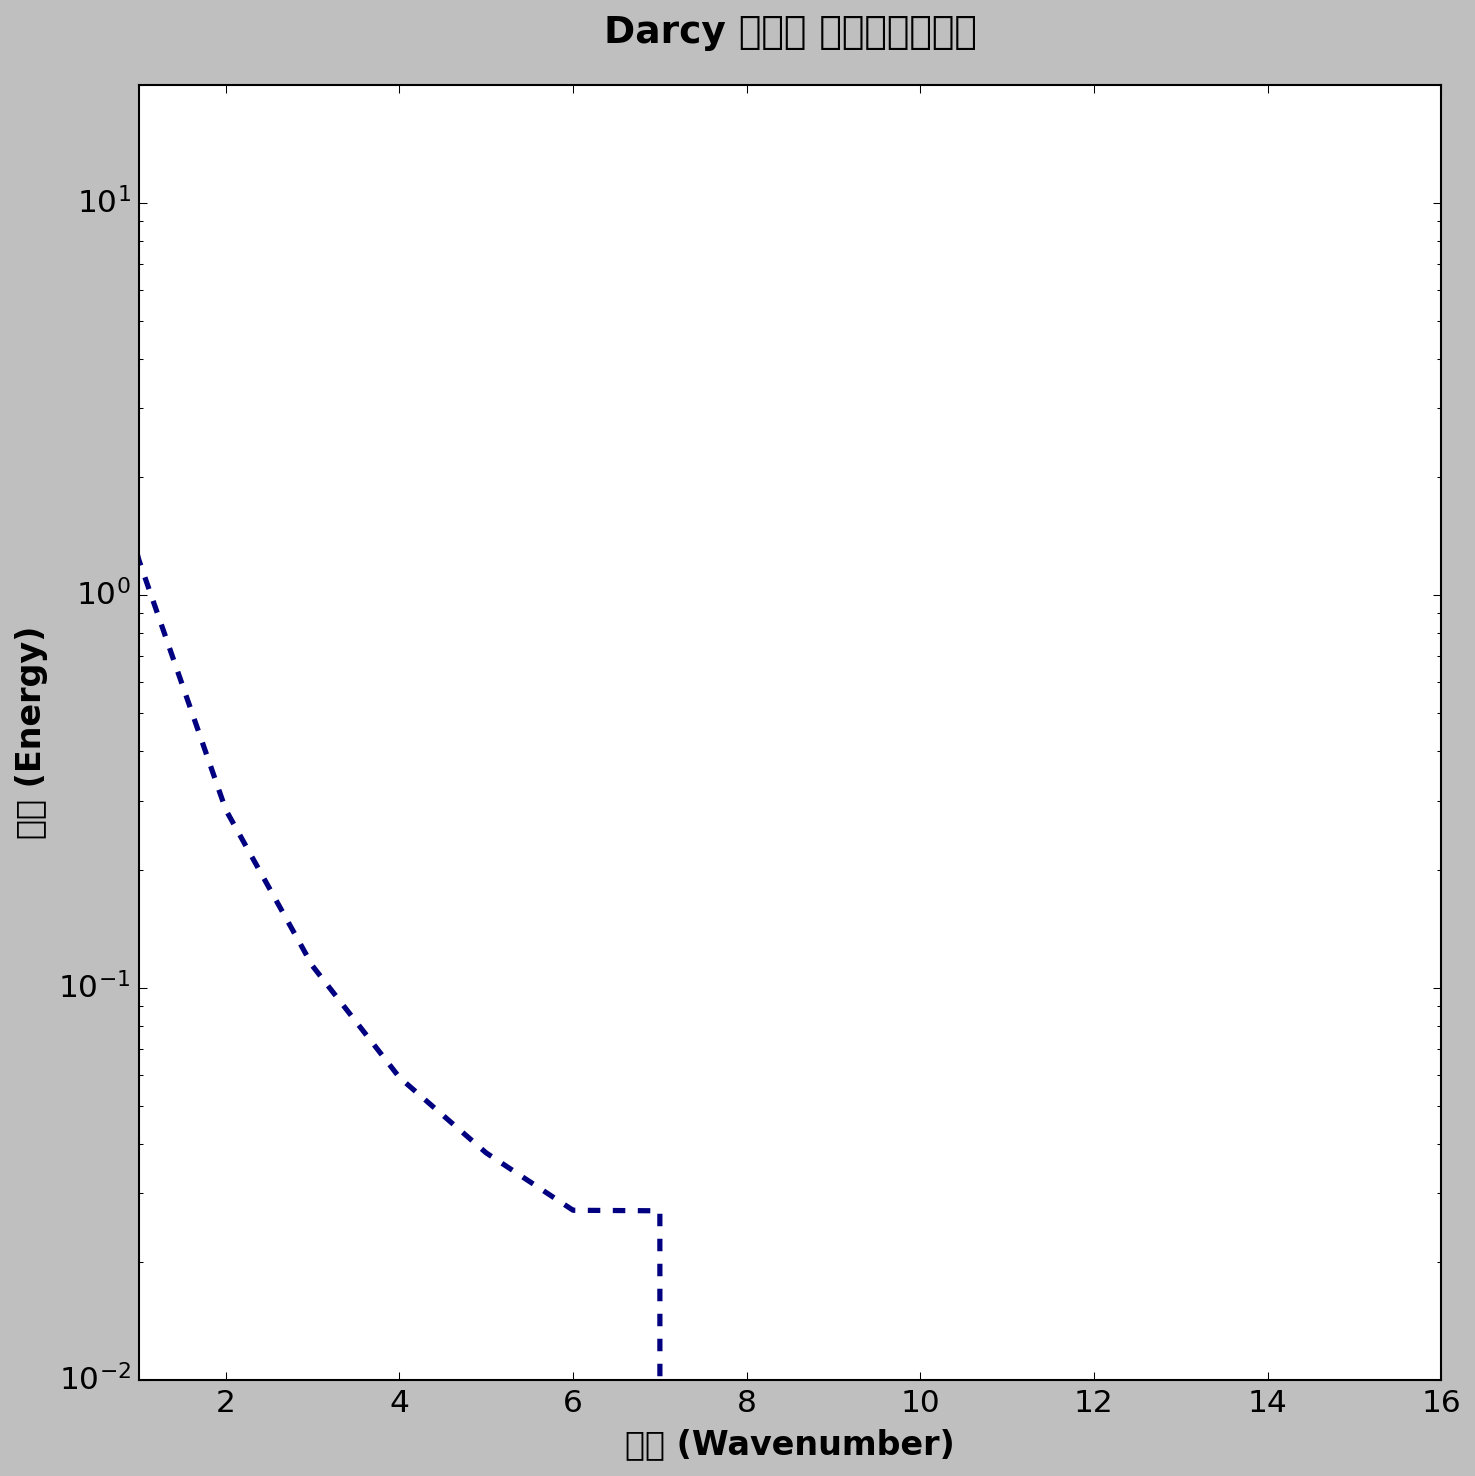

In [28]:
# 配置绘图样式和画布
plt.style.use("classic")  # 使用经典绘图样式
# 创建画布：尺寸10x10，分辨率150，保证图像清晰
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
ax.set_facecolor("white")  # 设置画布背景色为白色
ax.set_yscale("log")       # Y轴使用对数刻度：能更清晰展示能量的衰减趋势

# 获取数据集的分辨率边长，用于生成波数序列
length = dataset_pred.shape[-1]
buffer = 4  # 给波数序列增加缓冲区，优化绘图的视觉效果
k = np.arange(length + buffer) * 1.0  # 生成连续的波数序列

# 绘制能量谱曲线
ax.plot(
    truth_sp, 
    color="navy",         # 曲线颜色：藏青色
    linestyle="--",       # 曲线线型：虚线
    linewidth=2.5,        # 曲线宽度
    label="能量谱曲线"     # 图例标签
)

# 对图像做精细化样式配置
ax.set_xlim(1, 16)  # X轴范围：波数1~16（核心有效区间）
ax.set_ylim(0.01, 20) # Y轴范围：能量值0.01~20（对数刻度）
ax.set_xlabel("波数 (Wavenumber)", fontsize=16, fontweight="bold")  # X轴标签
ax.set_ylabel("能量 (Energy)", fontsize=16, fontweight="bold")      # Y轴标签
# 设置图像标题
ax.set_title(
    f"{dataset_name} 数据集的能量谱", 
    fontsize=18, 
    fontweight="bold", 
    pad=20
)
# 设置坐标轴刻度字体大小
ax.tick_params(axis="both", which="major", labelsize=15)

# 自动调整子图间距，防止文字重叠
plt.tight_layout()
# 显示绘制完成的图像
plt.show()


## ✅ 关键概念补充说明（必读，理解核心逻辑）
### 1. 波数(Wavenumber)
> 流体力学/频谱分析中的核心概念，**波数 = 2π/波长**，代表「单位空间内的波的数量」，是**空间频率**的量化指标。
> 波数越高 → 波长越短 → 对应流体的「小尺度细节特征」（比如渗流场的局部涡流、孔隙）
> 波数越低 → 波长越长 → 对应流体的「大尺度整体特征」（比如渗流场的宏观流动趋势）

### 2. 能量谱的物理意义
本次代码中 `spectrum_2d` 计算的能量谱，本质是**傅里叶变换后的功率谱密度**：
- 对压力场做二维傅里叶变换，得到不同波数的频率分量
- 对每个波数的频率分量求模的平方，得到该波数对应的能量
- 能量谱的衰减趋势，直接反映了：Darcy渗流场的能量主要集中在**低波数(低频)** 区间，高频分量的能量快速衰减。

### 3. 为什么要做频谱分析？
对Darcy渗流场这类物理数据集做频谱分析，主要目的：
① 量化数据集的**频率特征**，指导神经网络的设计（比如选择能高效拟合高频分量的模型）
② 评估模型的预测效果：好的模型需要同时拟合「低频大尺度特征」和「高频小尺度细节」
③ 揭示物理规律：渗流场的能量谱衰减规律，符合流体力学的经典湍流能量级串理论。